In [1]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00


In [2]:
import torch
print(torch.__version__)

2.0.0+cu118


In [3]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
import json
import ase
from ase import Atoms
import ase.neighborlist

import torch
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

from torch_geometric.loader import DataLoader
from torch_geometric.nn import  global_mean_pool, CGConv
from torch_geometric.data import DataLoader, Dataset, Data

In [11]:
dim = 60
cutoff = 10
batch_size = 64 
epochs = 20

def aseAtomsBuilder(filename):
#Using the preprocessing from the the example code to help with downstream tasks

  #Read json file
  json_path = filename
  f = open(json_path)
  structures = json.load(f)
  f.close()

  data_list = []
  for i, s in enumerate(structures): 
      data = Data()
      
      #construct ASE atoms object to compute neighbors and distances
      atoms = Atoms(numbers = s["atomic_numbers"], positions = s["positions"], cell = s["cell"])
      idx0, idx1, distance = ase.neighborlist.neighbor_list(
          "ijd",
          atoms,
          cutoff=cutoff,
          self_interaction=True,
      )
      
      data.edge_index = torch.stack([torch.LongTensor(idx0), torch.LongTensor(idx1)], dim=0)
      data.edge_attr = torch.tensor(distance).unsqueeze(-1).float()
      data.x = torch.tensor(s["atomic_numbers"]).unsqueeze(-1).float()
      data.y = torch.tensor([s["y"]])
      
      data_list.append(data)

  #Split into train, test, val

  return data_list

'''
dataSetLen = len(data_list)
startTrainIdx = 0
endTrainIdx = int(dataSetLen * 0.75)

startValIdx = endTrainIdx
endValIdx = int(dataSetLen * 0.8)

startTestIdx = endValIdx
endTestIdx = dataSetLen
'''

'\ndataSetLen = len(data_list)\nstartTrainIdx = 0\nendTrainIdx = int(dataSetLen * 0.75)\n\nstartValIdx = endTrainIdx\nendValIdx = int(dataSetLen * 0.8)\n\nstartTestIdx = endValIdx\nendTestIdx = dataSetLen\n'

In [12]:
f = open("train_data.json")
trainRawData = json.load(f)
f.close()

f = open("val_data.json")
valRawData = json.load(f)
f.close()

f = open("test_data.json")
testRawData = json.load(f)
f.close()

print(len(trainRawData))
print(len(valRawData))
print(len(testRawData))


5368
671
671


In [13]:
#Hyperparameters
batch_size = 64
num_workers = 0
depth = 2
divisor = 3
p1 = 0.3
p2 = 0.3
p3 = 0.3
hidden_channels = 150
lr = 0.0001
persistentWorkers = False

In [14]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.loader import ShaDowKHopSampler
from torch_geometric.nn import SAGEConv, global_mean_pool, TransformerConv, GATv2Conv, ChebConv, TAGConv

train_data = aseAtomsBuilder("train_data.json")
val_data = aseAtomsBuilder("val_data.json")
test_data = aseAtomsBuilder("test_data.json")


kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'persistent_workers': persistentWorkers}

train_loader = []
val_loader = []
test_loader = []

currIdx = 0
for x in train_data:
  totalNodes = len(trainRawData[currIdx]["positions"])
  train_loader.append(ShaDowKHopSampler(x, depth=depth, num_neighbors=50 // divisor, **kwargs))

currIdx = 0
for y in val_data:
  totalNodes = len(valRawData[currIdx]["positions"])
  val_loader.append(ShaDowKHopSampler(y, depth=depth, num_neighbors = totalNodes // divisor, **kwargs))

currIdx = 0
for z in test_data:
  totalNodes = len(testRawData[currIdx]["positions"])
  test_loader.append(ShaDowKHopSampler(z, depth=depth, num_neighbors = totalNodes // divisor, **kwargs))

print(len(val_loader))
print(len(test_loader))

671
671


In [ ]:
for d in train_loader[0]:
  print(d)



DataBatch(batch=[64], ptr=[9], root_n_id=[8], edge_index=[2, 512], edge_attr=[512, 1], x=[64, 1], y=[1, 1])


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for d in train_loader[0]:
  for b in d:
    print(Data(b))

Data(x=[2])
Data(x=[2])
Data(x=[2])
Data(x=[2])
Data(x=[2])
Data(x=[2])
Data(x=[2])


(array([669.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

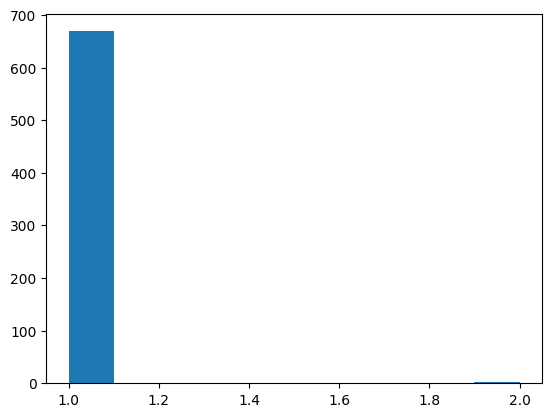

In [ ]:
plt.hist([len(k) for k in val_loader])

In [15]:

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.conv1 = ChebConv(in_channels, hidden_channels, 5)
        self.conv2 = TAGConv(hidden_channels, hidden_channels)
        self.conv3 = TransformerConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(2 * hidden_channels, out_channels)
        self.softmax = torch.nn.Softmax(dim = 0)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
      

    def forward(self, x, edge_index, batch, root_n_id):
        
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=p1)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=p2, training=self.training)
        x = self.conv3(x, edge_index).relu()
        x = F.dropout(x, p=p3, training=self.training)

        # We merge both central node embeddings and subgraph embeddings:
        x = torch.cat([x[root_n_id], global_mean_pool(x, batch)], dim=-1)
        x = self.lin1(x)
        x  = self.softmax(x)
        x = self.lin2(x)
        
        return x.mean(axis = 0).unsqueeze(-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(1, hidden_channels, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train():
    model.train()
    total_loss = total_examples = 0
    
    count = 0
    for data in train_loader:
      
      for subData in data:

        formattedData = subData.to(device)
        optimizer.zero_grad()
        out = model(subData.x, subData.edge_index, subData.batch, subData.root_n_id)
        loss = F.l1_loss(out, subData.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * subData.num_graphs
        total_examples += subData.num_graphs

    return total_loss / total_examples


@torch.no_grad()
def test(loader):
    model.eval()
    loss_all = 0
    minPrediction = 100
    maxPrediction = -5

    for data in loader:
      for subData in data:
        subData = subData.to(device)
        out = model(subData.x, subData.edge_index, subData.batch, subData.root_n_id)

        if out[0][0] < minPrediction:
          minPrediction = out[0][0]
        
        elif out[0][0] > maxPrediction:
          maxPrediction = out[0][0]

        loss = F.l1_loss(out, subData.y)
        loss_all += loss.item() * subData.num_graphs

    return loss_all / len(loader)


for epoch in range(1, 3):
    loss = train()
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, ',
          f'Val: {val_acc:.4f} Test: {test_acc:.4f}')

KeyboardInterrupt: ignored